In [1]:
import Pkg

#Pkg.add("Zygote")

using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots

In [2]:
train_x, train_y = CIFAR100(:train).features, CIFAR100(:train).targets
test_x, test_y = CIFAR100(:test).features, CIFAR100(:test).targets

train_x = permutedims(Float32.(train_x) ./ 255.0, (1,2,3,4))  
test_x = permutedims(Float32.(test_x) ./ 255.0, (1,2,3,4)) 

train_y = CIFAR100(:train).targets.fine
test_y = CIFAR100(:test).targets.fine

train_y = onehotbatch(vec(train_y), 0:99)  
test_y = onehotbatch(vec(test_y), 0:99)


;

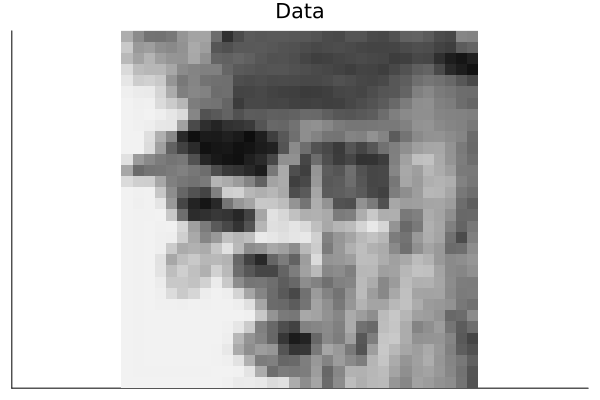

In [3]:
input_data = train_x[:, :, :, 1:1]

input_plot = heatmap(input_data[:, :, 1, 1], color=:grays, axis=nothing, title="Data", xticks=false, yticks=false, colorbar=false, aspect_ratio=:equal) 


In [4]:
conv1 = Conv((3,3), 3=>16, relu)
pool1 = MaxPool((2,2))
conv2 = Conv((3,3), 16=>32, relu)
pool2 = MaxPool((2,2))
conv3 = Conv((3,3), 32=>64, relu)
pool3 = MaxPool((2,2))
flatten = Flux.flatten
dense1 = Dense(256, 128, relu)
dense2 = Dense(128, 100)


model = Chain(conv1, pool1, BatchNorm(16), conv2, pool2, BatchNorm(32), conv3, pool3, BatchNorm(64), flatten, dense1, dense2, softmax)

loss(m, x, y) = crossentropy(m(x), y)

opt = ADAM();

In [48]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    epoch_loss = []

    for epoch in 1:epochs

        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.crossentropy(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)
            
            push!(epoch_loss, loss(model, x, y))
        end
        println("Epoch $epoch complete")
    end
    return epoch_loss
end

train_model! (generic function with 1 method)

In [68]:
epochs = 3
batch_size = 64;

64

In [49]:
loss_list = train_model!(model, train_x, train_y, opt, epochs, batch_size);

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete


In [72]:
plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=(1:epochs, ["" for i in 1:epochs]), yticks=(loss_list, ["" for i in loss_list]))

In [51]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_x, test_y))


Test Accuracy: 0.0246


In [133]:
function visualize_layer(input_data, layer, filter_labels)
    output = layer(input_data)  # Apply the convolutional layer

    num_filters = size(output, 4)  # Number of output channels

    # Create input plot
    input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title="Input", xticks=false, yticks=false, colorbar=false)

    # Create output plots for each filter response with labels
    output_plots = [
        heatmap(output[:, :, 1, i], axis=nothing, 
                title=filter_labels,
                xticks=false, yticks=false, colorbar=false) 
        for i in 1:num_filters
    ]

    # Arrange plots in a grid (side by side)
    plot(input_plot, output_plots..., layout=(1, num_filters + 1))
end

using Flux

# Define each filter as a 3x3 matrix
f1 = [ 0  -1  0; -1  4 -1;  0  -1  0 ]
f2 = [ 0  -1  0; -1  9 -1;  0  -1  0 ]
f3 = [ 1   2  1;  0  0  0; -1  -2 -1 ]
f4 = [ 1   0 -1;  2  0 -2;  1   0 -1 ]
f5 = (1/16).*[ 1   2  1;  2  4  2;  1   2  1 ]
f6 = [-2  -1  0; -1  1  1;  0   1  2 ]

f7 = (1/273).*[ 1 4 7 4 1; 4 16 26 16 4; 7 26 41 26 7; 4 16 26 16 4; 1 4 7 4 1 ] 
f8 = (1/1003) .* [ 0 0 1 2 1 0 0; 0 3 13 22 13 3 0; 1 13 59 97 59 13 1; 2 22 97 159 97 22 2; 1 13 59 97 59 13 1; 0 3 13 22 13 3 0; 0 0 1 2 1 0 0 ]
f9 = (1/9) .* [ 1 1 1; 1 1 1; 1 1 1 ]

f10 = (-1/256).*[ 1 4 6 4 1; 4 16 24 16 4; 6 24 -476 24 6; 4 16 24 16 4; 1 4 6 4 1 ]

f11 = [ 4 0 1 0 1; 0 0 0 0 0; 1 0 10 0 1; 0 0 0 0 0; 1 0 1 0 1]

f12 = (1/14).*[ 20 5 20; 5 0 5; 20 5 20]

# Reshape each filter to include the input channel and output channel dimensions (3, 3, 1, 1)
f1_tensor = reshape(f1, (3, 3, 1, 1))
f2_tensor = reshape(f2, (3, 3, 1, 1))
f3_tensor = reshape(f3, (3, 3, 1, 1))
f4_tensor = reshape(f4, (3, 3, 1, 1))
f5_tensor = reshape(f5, (3, 3, 1, 1))
f6_tensor = reshape(f6, (3, 3, 1, 1))
f7_tensor = reshape(f7, (5, 5, 1, 1))
f8_tensor = reshape(f8, (7, 7, 1, 1))
f9_tensor = reshape(f9, (3, 3, 1, 1))
f10_tensor = reshape(f10, (5, 5, 1, 1))
f11_tensor = reshape(f11, (5, 5, 1, 1))
f12_tensor = reshape(f12, (3, 3, 1, 1))

# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing",
    "Large Gaussian Blur",
    "Super Large Gaussian Blur",
    "Box Blur",
    "Unsharp Masking",
    "Every Other",
    "Inverse Gaussian Blur"
];

n = length(filter_labels)

;

conv_layer_1 = Conv((3, 3), 1=>6, custom_filters[1])  # 1 input channel, 5 output channels
#conv_layer_1.weight .= custom_filters[1]  # Assign custom filters to the convolution layer

conv_layer_2 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_2.weight .= custom_filters[2]

conv_layer_3 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_3.weight .= custom_filters[3]

conv_layer_4 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_4.weight .= custom_filters[4]

conv_layer_5 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_5.weight .= custom_filters[5]

conv_layer_6 = Conv((3, 3), 1=>6, identity)  # 1 input channel, 5 output channels
conv_layer_6.weight .= custom_filters[6]



In [134]:
pad_set = 0
stride_set = 1
choice = 2
;

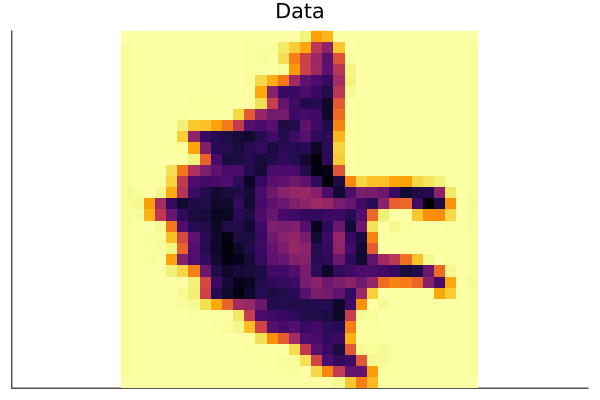

In [135]:
input_data = train_x[:, :, :, choice:choice]

input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title="Data", xticks=false, yticks=false, colorbar=false, aspect_ratio=:equal) 



In [136]:
conv_layer_1 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_1.weight .=f1_tensor

conv_layer_2 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_2.weight .=f2_tensor

conv_layer_3 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_3.weight .=f3_tensor

conv_layer_4 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_4.weight .=f4_tensor

conv_layer_5 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_5.weight .=f5_tensor

conv_layer_6 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_6.weight .=f6_tensor;

conv_layer_7 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_7.weight .=f7_tensor;

conv_layer_8 = Conv((7,7), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_8.weight .=f8_tensor;

conv_layer_9 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_9.weight .=f9_tensor;

conv_layer_10 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_10.weight .=f10_tensor;

conv_layer_11 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_11.weight .=f11_tensor;

conv_layer_12 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_12.weight .=f12_tensor;



;

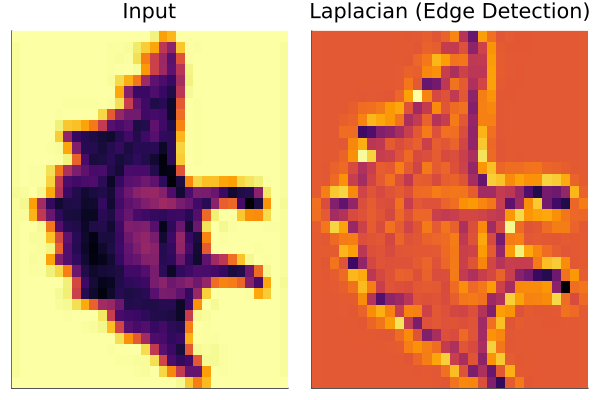

In [137]:
visualize_layer(input_data, conv_layer_1, filter_labels[1])

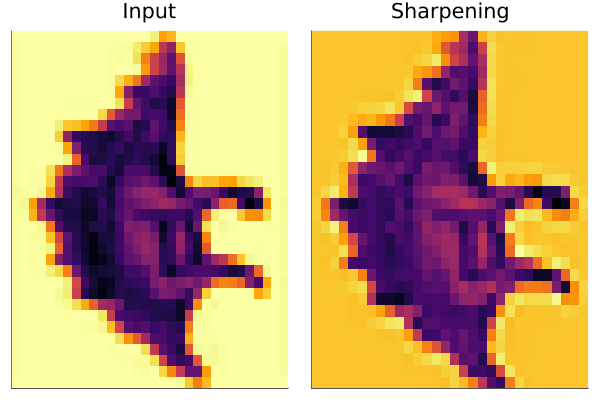

In [138]:
visualize_layer(input_data, conv_layer_2, filter_labels[2])

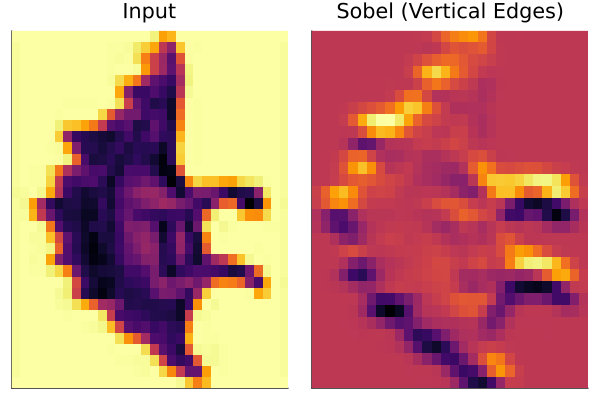

In [139]:
visualize_layer(input_data, conv_layer_3, filter_labels[3])

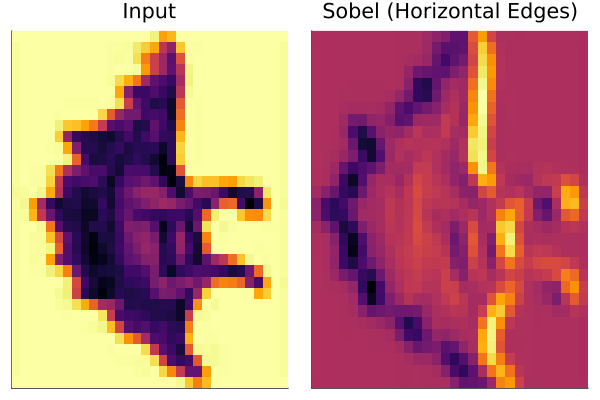

In [140]:
visualize_layer(input_data, conv_layer_4, filter_labels[4])

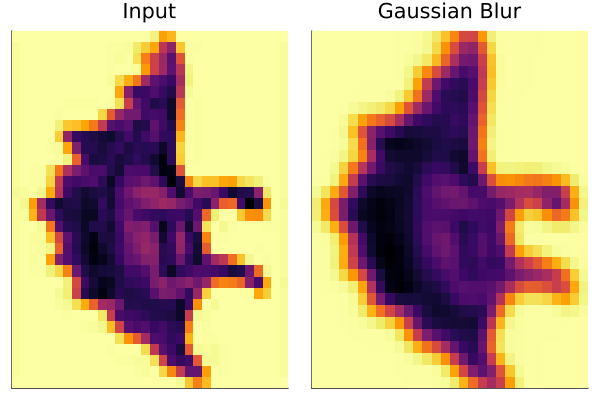

In [141]:
visualize_layer(input_data, conv_layer_5, filter_labels[5])

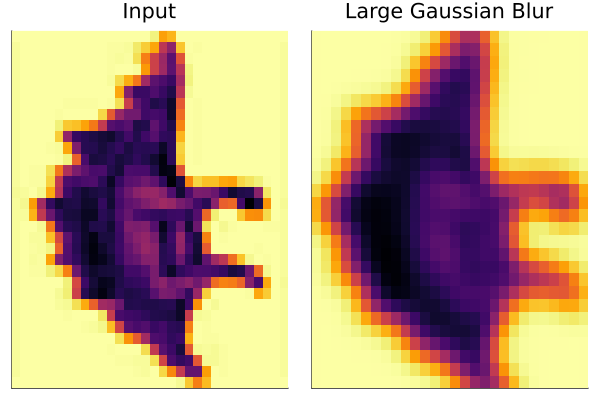

In [142]:
visualize_layer(input_data, conv_layer_7, filter_labels[7])

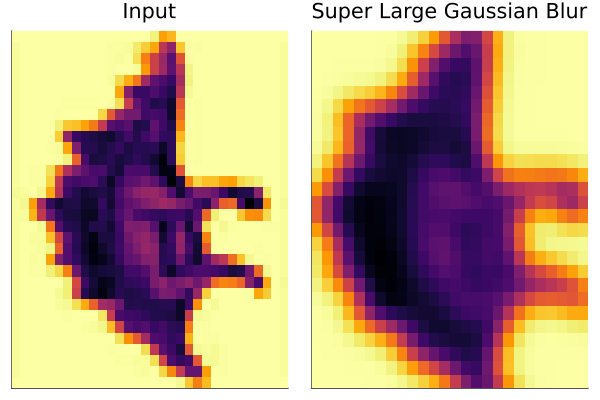

In [143]:
visualize_layer(input_data, conv_layer_8, filter_labels[8])

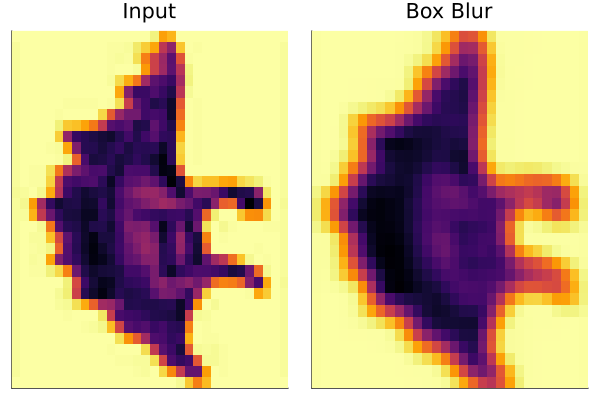

In [144]:
visualize_layer(input_data, conv_layer_9, filter_labels[9])

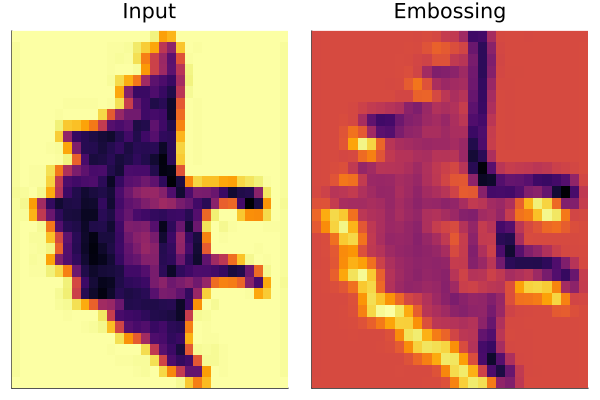

In [145]:
visualize_layer(input_data, conv_layer_6, filter_labels[6])

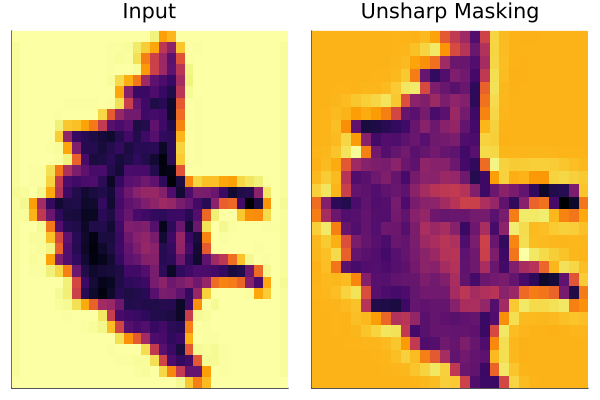

In [146]:
visualize_layer(input_data, conv_layer_10, filter_labels[10])

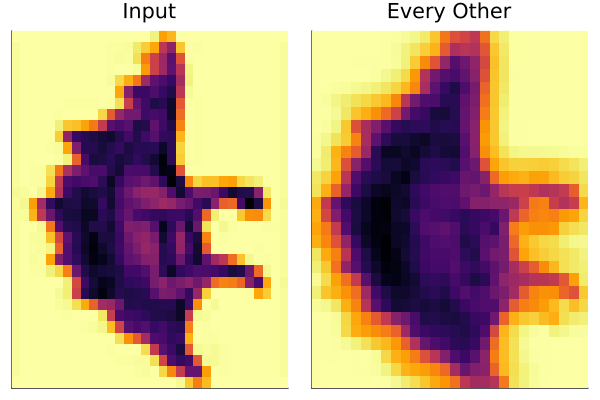

In [147]:
visualize_layer(input_data, conv_layer_11, filter_labels[11])

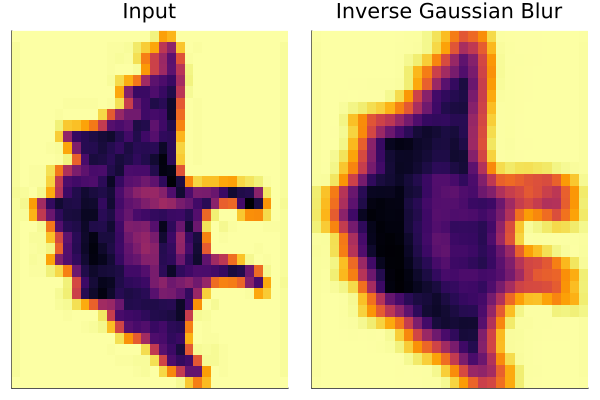

In [148]:
visualize_layer(input_data, conv_layer_12, filter_labels[12])